# Image Processing Project

### Project:
    Straighten the Image

### Group Members:
    Aoife Toomey (C17342383)
    Kseniia Klimenko (D17123220)
    Luka Dragar (D20124481)

### Due Date: 
    27/11/2020

## Overview of Group Assignment


## Code
Step by Step of Code 

In [5]:
# Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt 
#from matplotlib import image as image
#import easygui # An easy-to-use file-picker; pip install easygui
from collections import Counter
import os
import easygui
from skimage.transform import probabilistic_hough_line


In [17]:
# Constants

# default weights for calculating
# w1 - median angle
# w2 - longest line
# w3 - every line
# w4 - parallel lines
# w5 - perpendicular lines
# w6 - flat lines (vertical or horizontal)
DEFAULT_WEIGHTS = [1, 2, 0.1, 1.25, 1.5, 1]
ROTATE_AND_EXPAND = 1
ROTATE_AND_CROP = 2
ROTATE_AND_KEEP = 0


# Functions

def calculate_angle(image : np.ndarray, 
                    hough_lines : np.ndarray = None, 
                    hough_lines_p : np.ndarray = None, 
                    weights : list = DEFAULT_WEIGHTS, 
                    significance : float = 10 ) -> float:
    '''
    Calculates the most important angle, or angle to which need to rotate image to get it straight

    Parameters
    ----------
    image (OpenCV image) :
        Image imported by OpenCV to calculate dimensions from
    
    hough_lines (OpenCV HoughLine) :
        List of lines provided by OpenCV HoughLine function
    
    hough_lines_p (OpenCV HoughLineP) :
        List of lines provided by OpenCV HoughLineP function
    
    weights (list) :
        List of weights for calculating lines importance:
            w1 - median angle;  
            w2 - longest line;  
            w3 - every line;  
            w4 - parallel lines;    
            w5 - perpendicular lines; 
            w6 - flat (vertical or horizontal line)
        The default is DEFAULT_WEIGHTS.

    significance (float) :
        Define line with length of what percentage of image's diagonal considred to be signifficant. Default is 10%

    Returns
    -------
    The most important angle of image

    '''
    
    # check if image has 'shape'
    if 'shape' not in dir(image):
        raise TypeError("No image provided, or it is of incorrect type")
    # get pictiure dimensions
    elif len(image.shape) == 3:
        # for colour and other 3-dimensional spaces
        height, width, depth = image.shape
    elif len(image.shape) == 2:
        # for greyscale space
        height, width = image.shape
    # raise exception as can't proceed
    else:
        raise ValueError("Provided image is in incorrect format")
    
    # check if either hough_lines or hough_lines_p was provided
    if hough_lines is None and hough_lines_p is None:
        raise ValueError("Both hough_lines and hough_lines_p can't be empty!")
    
    # check if weights list is in correct format
    if type(weights) != list:
        raise TypeError('Weights list is of incorrect type')
    elif len(weights) != 6:
        raise ValueError('Weights list is in incorrect format')
    
    final_angle = 0
    diagonal = np.round(np.sqrt(height**2 + width**2))
    significance = significance / 100 if significance >= 1 else significance
    
    # unpack weights
    weight_median, weight_length, weight_each, weight_par, weight_perp, weight_flat = weights
    
    # compose all angles from both hough_lines and hough_lines_p into one list of dictionaries
    angles = []
    
    if hough_lines is not None:
        for line in hough_lines:
            # catch exceptions if for some reason format is wrong
            try:
                # get angle (in radians)
                theta = line[0][1]
                # convert to degrees
                theta = np.degrees(theta)
                # add angle to the list with empty length
                angles.append({'angle': theta, 'length': -1 })
            except:
                raise ValueError("hough_lines is in incorrect format")
    
    if hough_lines_p is not None:
        for line in hough_lines_p:
            # catch exceptions if for some reason format is wrong
            try:
                # get line' extreme points
                x1, y1, x2, y2 = line[0]
                # calculate length
                length = np.round( np.sqrt((x2-x1)**2 + (y2-y1)**2), 1)
                # calculate angle
                theta = np.arctan2(y2-y1, x2-x1) # - np.pi/2
                # convert to degrees and shift 90 degrees to match output of hough_lines
                theta = np.round(np.degrees(theta)) - 90
                if theta < 0:
                    theta = theta + 180
                    
                # process only "significant" lines, which are lengthier than "significance" percentage of image's diagonal
                if length >= diagonal * significance:
                    # add angle to the list with empty length
                    angles.append({'angle': theta, 'length': length })
            except:
                raise ValueError("hough_lines_p is in incorrect format")
    

    # sort angles by length ascending order
    angles = sorted(angles, key = lambda angle: angle['length'], reverse=True)
    # separate angles from their length
    just_angles = [element['angle'] for element in angles]
    # sum count lines with same angles
    counted_angles = Counter(just_angles).most_common()
    # get unique angles
    unique_angles = set(just_angles)

    # calculate weighted lines
    weighted_angles = {}
    

    # Add median angle with 'w1' weight
    weighted_angles[np.median(just_angles)] = weighted_angles.get(np.median(just_angles), 0) + weight_median
 
 
    # Add longest line with 'w2' weight (but only if it is longer than 0)
    longest = angles[0]['length'] if angles[0]['length'] > 0 else 0
    for line in angles:
        # get longest line (may be multiple lines with different angles)
        if line['length'] >= longest:
            weighted_angles[line['angle']] = weighted_angles.get(line['angle'], 0) + weight_length
        else:
            # stop processing lines, as it is already shorter than the longest one
            break
    
    
    # Add each line with 'w3' weight
    for angle in just_angles:
        weighted_angles[angle] = weighted_angles.get(angle, 0) + weight_each
    
    
    # Add parallel lines with 'w4' weight
    # get only angles where count > 1 (same angle so parallel lines)
    for line in [(element[0], element[1]) for element in counted_angles if element[1] > 1]:
        weighted_angles[line[0]] = weighted_angles.get(line[0], 0) + line[1] * weight_par
    
    
    # Add perpendicual lines with 'w5' weight
    for angle in just_angles:
        # check if there is a perpendicualr pair (+/- 90) and get lowest of pair
        if (angle + 90) in unique_angles:
            pair_angle = angle
        elif (angle - 90) in unique_angles:
            pair_angle = angle - 90
        else:
            pair_angle = -1

        # if pair found: add as weighted
        if pair_angle != -1:
            weighted_angles[pair_angle] = weighted_angles.get(pair_angle, 0) + weight_perp
            
    
    # Add flat (vertical or horizontal) lines with 'w6' weight
    for angle in just_angles:
        if angle == 90.0 or angle == 0.0 or angle == 180.0:
            weighted_angles[angle] = weighted_angles.get(angle, 0) + weight_flat
    
    
    # calculate the most important angle - the one with most entries in weighted list
    final_angle = max(weighted_angles, key = weighted_angles.get)
    
    # translate angle between 0 and 180 degrees to the most suitable rotation angle
    # 0   <= theta < 45   then theta
    # 45  <= theta < 135  then theta - 90
    # 135 <= theta <= 180 then theta - 180
    # positive number is anti-clockwise, where negative number is clockwise
    
    if final_angle >= 45 and final_angle < 135:
        final_angle = final_angle - 90
    elif final_angle >= 135 and final_angle <= 180:
        final_angle = final_angle - 180
    # else - no change in angle
    
    # return the most important angle
    return final_angle


def rotate_image(image : np.ndarray, 
                 degrees : float = 0, 
                 rotation_type : int = ROTATE_AND_CROP) -> np.ndarray:
    '''
    Rotates image by given angle anti-clockwise with given type of post-processing 

    Parameters
    ----------
    image (OpenCV image) :
        Image imported by OpenCV to rotate
    
    degrees (float): 
        Degrees to rotate image anti-clockwise. For clockwise rotation, provide negative value. The default is 0.
    
    rotation_type (int) :
        Post-processing of rotation. 
        Possible values: 
            ROTATE_AND_KEEP (0) - rotate but keep canvas size. Cuts corners after rotation. 
            ROTATE_AND_EXPAND (1) - rotate and expand canvas size. Expands to fit rotated image. 
            ROTATE_AND_CROP (2) - rotate and crop image to keep only image information and remove black areas from rotation. 
        The default is ROTATE_AND_CROP

    Returns
    -------
    Rotated image 

    '''
    
    # check if image has 'shape'
    if 'shape' not in dir(image):
        raise TypeError("No image provided, or it is of incorrect type")
    # get pictiure dimensions
    elif len(image.shape) == 3:
        # for colour and other 3-dimensional spaces
        height, width, depth = image.shape
    elif len(image.shape) == 2:
        # for greyscale space
        height, width = image.shape
    # raise exception as can't proceed
    else:
        raise ValueError("Provided image is in incorrect format")
        
    # get center of rotation/image
    cx = width // 2
    cy = height // 2
    # do not scale, keep as is
    scale = 1
    
    # Prepare rotation matrix
    M = cv2.getRotationMatrix2D(center = (cx,cy), angle = degrees, scale = scale)
    new_width = width * scale
    new_height = height * scale    
    
    if rotation_type == ROTATE_AND_EXPAND or rotation_type == ROTATE_AND_CROP:
        # in case of expanding and cropping - calculate expanded matrix and new dimensions
        '''
            Details taken from https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
        '''
        # rotate expanding bounds of image to not cut it off
        # cos and sin of the rotation's angle can be taken from rotation matrix
        cos_t = np.abs(M[0,0])
        sin_t = np.abs(M[0,1])

        # get new width and height using polar to cartesian translation 
        new_width = int(height * sin_t + width * cos_t)
        new_height = int(height * cos_t + width * sin_t)
    
        # Adjust matrix to move rotated image and make sure any part is not outside
        M[0,2] = M[0,2] + (new_width / 2) - cx
        M[1,2] = M[1,2] + (new_height / 2) - cy
    

    # do actual rotation (and expansion if needed)
    rotated_image = cv2.warpAffine(image, M = M, dsize = (new_width, new_height))

    if rotation_type == ROTATE_AND_CROP:
        # in case of cropping - calculate size of the most effective area fitting into rotated image
        '''
            Details taken from https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
        '''
        # get long and short side
        side_long, side_short = (width, height) if width >= height else (height, width)
        
        # calculate new dimensions of fitted image (for cropping)
        if side_short <= 2.0 * sin_t * cos_t * side_long or abs(sin_t - cos_t) < 1e-10:
            # half constrained case: two crop corners touch the longer side,
            # the other two corners are on the mid-line parallel to the longer line
            x = 0.5 * side_short
            crop_width, crop_height = ( x / sin_t, x / cos_t) if width >= height else ( x / cos_t, x / sin_t)
        else:
            # fully constrained case: crop touches all 4 sides
            cos_2t = cos_t * cos_t - sin_t * sin_t
            crop_width, crop_height = (width * cos_t - height * sin_t) / cos_2t, (height * cos_t - width * sin_t) / cos_2t

        # get coordinates of the new dimension
        dx = int(np.round((new_width - crop_width) / 2))
        dy = int(np.round((new_height - crop_height) / 2))
        
        # crop image
        rotated_image = rotated_image[dy : new_height - dy, dx : new_width - dx]
        
    # return rotated image
    return rotated_image


def getLines(img, expectedNumOfLines, numOfLinesVariance):

    # range for number of lines that we wish to detect
    lowerNumOfLines = expectedNumOfLines - numOfLinesVariance
    upperNumOfLines = expectedNumOfLines + numOfLinesVariance

    # starting parameters for the line detection
    numOfLines = 0

    bilateralBlurStrength = 7

    improveContrast = True
    useBilateralBlur = True

    houghLineTransformThreshold = 50
    houghLineTransformMinLength = 100

    # in case of infinite looping
    numberOfLoopsAllowed = 30
    loopsCounter = 0

    # reading and resizing the image to speed up further processing
    imgBlack = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    width = imgBlack.shape[1]
    height = imgBlack.shape[0]

    if width > height:
        newHeight = int(1000 * height / width)
        imgBlack = cv2.resize(imgBlack, (1000, newHeight), cv2.INTER_AREA)
    else:
        newWidth = int(1000 * width / height)
        imgBlack = cv2.resize(imgBlack, (newWidth, 1000), cv2.INTER_AREA)

    while numOfLines < lowerNumOfLines or numOfLines > upperNumOfLines:
        imgBlackCopyHoughLinesP = imgBlack.copy()

        if numOfLines < lowerNumOfLines:
            bilateralBlurStrength = bilateralBlurStrength - 1
        elif numOfLines > upperNumOfLines:
            bilateralBlurStrength = bilateralBlurStrength + 1

        if bilateralBlurStrength > 20:
            houghLineTransformMinLength += 50
        elif bilateralBlurStrength > 15:
            improveContrast = False
        elif bilateralBlurStrength == 0:
            useBilateralBlur = False

        if improveContrast:
            imgBlackCopyHoughLinesP = cv2.equalizeHist(imgBlackCopyHoughLinesP)
            imgBlackCopyHoughLinesP = cv2.createCLAHE(1, (5, 5)).apply(imgBlackCopyHoughLinesP)

        if useBilateralBlur:
            blurredImg = cv2.bilateralFilter(imgBlackCopyHoughLinesP, bilateralBlurStrength, 100, 100)
        else:
            blurredImg = imgBlackCopyHoughLinesP

        # Canny edge detection
        cannyLowThreshold = np.median(blurredImg) - blurredImg.std()
        cannyHighThreshold = np.median(blurredImg) + blurredImg.std()
        imgEdges = cv2.Canny(blurredImg, cannyLowThreshold, cannyHighThreshold, 3)

        # Hough line p transform
        houghLinesP = cv2.HoughLinesP(imgEdges, 1, np.pi / 180, houghLineTransformThreshold,
                               minLineLength=houghLineTransformMinLength, maxLineGap=50)
        
        if houghLinesP is None:
            numOfLines = 0
        else:      
            numOfLines = len(houghLinesP)

        if loopsCounter > numberOfLoopsAllowed:
            break
        loopsCounter = loopsCounter + 1

    # Normal hough line transform
    houghLines = cv2.HoughLines(imgEdges, 1, np.pi / 180, 200)


    return houghLinesP, houghLines


# Hough
def printLinesToImage(img_P, lines):
    for x in range(0, len(lines)):
        for rho, theta in lines[x]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            
            cv2.line(img_P, (x1, y1), (x2, y2), (0, 255, 0), 2)

#blurred image
def blur_image(img_B, blur):
    blurred_img_gray = cv2.GaussianBlur(img_B, (blur, blur), 0)
    #blurred_img_gray = cv2.GaussianBlur(img_B, (5, 5), 0)
    # plt.imshow(blurred_img_gray, cmap = plt.cm.gray)
    # plt.show()
    cv2.imwrite("Grayscale_blur.jpg", blurred_img_gray)
    return blurred_img_gray

#Canny on grayscale image
def Canny(img_C):
    edges_gray = cv2.Canny(img_C, 99, 100)
    # plt.imshow(edges_gray, cmap = plt.cm.gray)
    # plt.show()
    cv2.imwrite("Canny_on_gray.jpg", edges_gray)
    return edges_gray

def finish(img_F, l):
    printLinesToImage(img_F, l)
    # plt.imshow(img_F)
    # plt.show()
    second = cv2.cvtColor(img_F, cv2.COLOR_RGB2BGR)
    cv2.imwrite("Result.jpg",second)


def Check_Single_Horizon_Line(img):
    
    #Convert to RGB
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    blur_value = 3
    first_image_copy = img2.copy()
    second_image_copy = img2.copy()
    another_copy = img2.copy()
    copy_gray = cv2.cvtColor(another_copy, cv2.COLOR_BGR2GRAY)
    

    blur_image_res = blur_image(copy_gray, blur_value)
    gray_edges_result = Canny(blur_image_res)


    lines = cv2.HoughLines(gray_edges_result,1 , np.pi / 180, 100, 255)
    if lines is None:
        while lines is None:
            print(blur_value)
            blur_value -= 2
            blur_image_res = blur_image(copy_gray, blur_value)
            gray_edges_result = Canny(blur_image_res)
            lines = cv2.HoughLines(gray_edges_result, 1, np.pi / 180, 100, 255)
            if(blur_value == 1 or len(lines) > 0):
                break;   
    else:
        return lines
  
    return lines


Angle is: 3.0 degrees


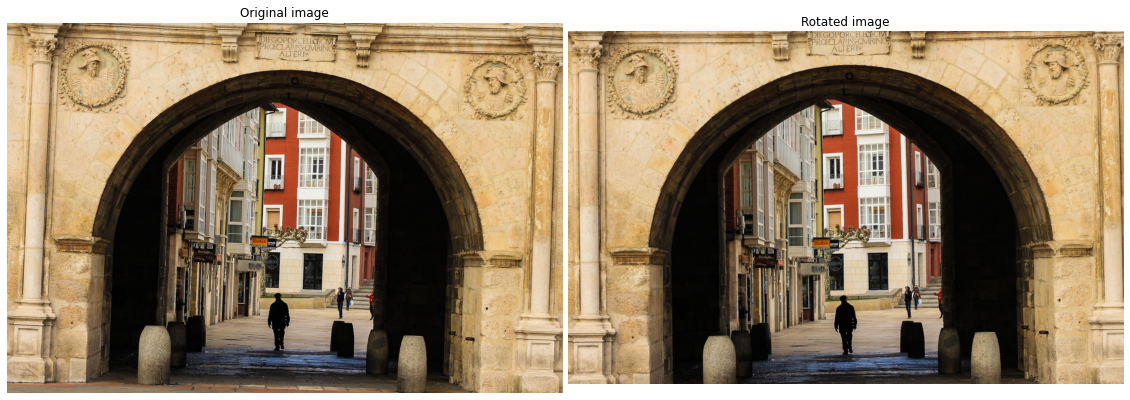

In [23]:
selectedFiles = easygui.fileopenbox("You can choose multiple", "Image Select", filetypes=["*.png", "*.jpg"], multiple=True)

for num, image in enumerate(selectedFiles, start=1):
    
    img = cv2.imread(image)
    
    horizonLine = Check_Single_Horizon_Line(img)
    
    if (horizonLine is not None):
        if len(horizonLine) > 1:
            hough_lines_p, hough_lines = getLines(img, 100, 99)
            angle = calculate_angle(img, hough_lines, hough_lines_p)

        elif len(horizonLine) == 1:
            angle = horizonLine[0][0][1]
            angle = np.degrees(angle)-90

        print('Angle is:', angle,'degrees')
        rotated_image = rotate_image(img, angle)
        
        head, tail = os.path.split(image)
        filename = "rotated-" + tail
        cv2.imwrite(filename, rotated_image)

        # draw
        fig, axs = plt.subplots(1, 2, figsize=(20,10), gridspec_kw={'wspace': 0.01, 'hspace': 0})
        x = axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        x = axs[1].imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
        x = axs[0].set_title('Original image')
        x = axs[1].set_title('Rotated image')
        x = axs[0].axis('off')
        x = axs[1].axis('off')